# MVA 2017-2018
## Probalistic Graphical Model - Homework 3
### Bastien PONCHON

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
% matplotlib inline

In [132]:
#loading data: change folder name depending on file tree
dataTrain = np.loadtxt('./data/EMGaussian.data')
dataTest = np.loadtxt('./data/EMGaussian.test')

In [3]:
print("Train data:",  np.size(dataTrain[:, 0]),  "points")
print("Test data:", np.size(dataTest[:,0]), "points")

Train data: 500 points
Test data: 500 points


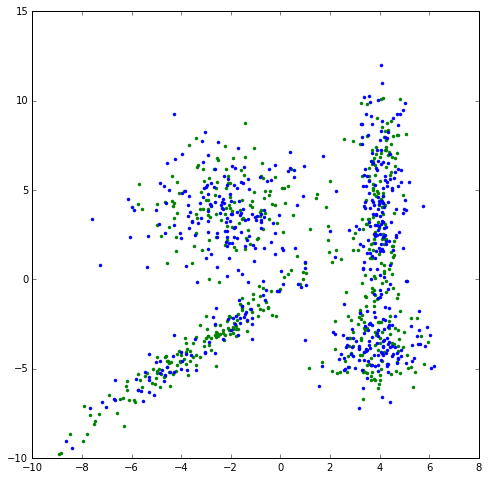

In [4]:
plt.figure(figsize=(8,8))
plt.plot(dataTrain[:, 0],dataTrain[:, 1], 'g.')
plt.plot(dataTest[:, 0],dataTest[:, 1], 'b.')

In [5]:
def designMatrixPreproc(X): #centering and normalizing the Nx2 design matrix X
    meanX = np.mean(X,axis=0)
    Xcent = X - meanX
    stdX = np.std(Xcent, axis=0)
    newX = Xcent/stdX
    return newX

In [133]:
dataTrain = designMatrixPreproc(dataTrain)
dataTest = designMatrixPreproc(dataTest)

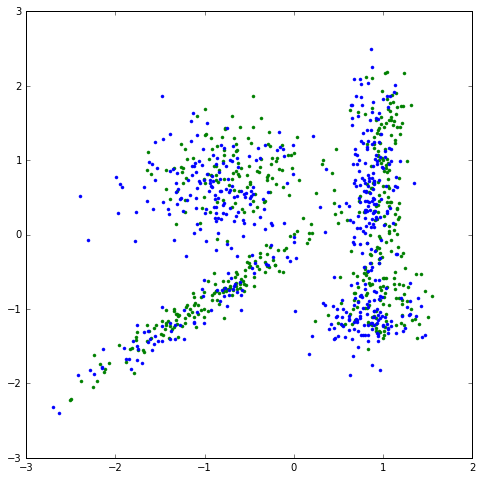

In [7]:
plt.figure(figsize=(8,8))
plt.plot(dataTrain[:, 0],dataTrain[:, 1], 'g.')
plt.plot(dataTest[:, 0],dataTest[:, 1], 'b.')

#### 1. Alpha-pass and Beta-pass algorithms

In [8]:
class Gauss:
    #a class for gaussian distributions
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def probCond(self, x):
        #computes the probability of X (of size 2x1 for a two variate gaussian) in a gaussian model of paramters mu and sigma
        #ie. returns the image of x by the normal function of mean mu and covariance sigma
        # x and mu must be arrays of size k (2 in our case)
        mu = self.mu
        sigma = self.sigma
        scal = (np.dot(np.dot([x-mu], np.linalg.inv(sigma)), np.transpose([x-mu])))[0][0]
        return (np.exp(-scal/2.)/math.sqrt(2*math.pi*np.linalg.det(sigma)))

In [9]:
mu = np.array([1,3])
sigma = np.array([[1, 0], [0, 1]])
x = np.array([13,2])

In [10]:
p1 = Gauss(mu, sigma)
p1.probCond(x)
x*mu

array([13,  6])

In [11]:
class HMM:
    #HMM class: K is the number of state, pi the initial probability distribution, A the transition matrix, and P the set of emmission distributions
    def __init__(self, K, pi, A, P):
        self.K = K
        self.pi = pi
        self.P = P
        self.A = A
    
    def alphaPass(self, X):
        # Alpha recursion algorithm for a sequence X of T observations (X of size Tx2 in our case of two-variate observations)
        # Returns the matrix of scaled alphas of size TxK where K is the number of states
        T = np.size(X[:,0])
        K = self.K
        pi = self.pi
        P = self.P
        A = self.A
       
        alpha = np.zeros((T, K))
        alpha[0,:] = np.array([p.probCond(X[0,:]) for p in P])*pi
            
        for t in range(1, T):
            alpha[t,:] = np.array([P[j].probCond(X[t,:])*np.sum(np.array([A[i,j]*alpha[t-1, i] for i in range(K)])) for j in range(K)])
            
        return alpha
    
    
    def alphaPassScaled(self, X):
        # Scaled version of the forward algorithm, in order to overcome the underflow issue due to the length...
        # ... of the sequence we will be working with (500)
        # Beware ! The algorithm does not return p(q_t, u_0, ..., u_t) for all t and q_t as in the non scaled version,...
        # ... but p(q_t | u_0, ..., u_t) for all t and q_t.
        # The function also returns the scaling_coefficients, which are equal to p(u_0, ..., u_t), for all t.
        T = np.size(X[:,0])
        K = self.K
        pi = self.pi
        P = self.P
        A = self.A
        
        #scaling coefficients to avoid underflow, each of them is equal to the sum of alphas at time t for the various possible state
        # As alpha_t(z_t) = p(z_t, y_0, ..., y_t), these coefficients are thus equalt to p(z_0...z_t)
        scaling_coef = np.zeros(T)
        
        alpha = np.zeros((T, K))
        alpha[0,:] = np.array([p.probCond(X[0,:]) for p in P])*pi
        
        # Normalizing the alphas in order to avoid underflow (keep the probability values in the dynamic range of the machine)
        # Note that the new alpha is thus equal to p(z_t | y_0, ..., y_t)
        c = np.sum(alpha[0])
        alpha[0,:] = alpha[0,:]/c
        scaling_coef[0] = c 

            
        for t in range(1, T):
            alpha[t,:] = np.array([P[j].probCond(X[t,:])*np.sum(np.array([A[i,j]*alpha[t-1, i] for i in range(K)])) for j in range(K)])
            c = np.sum(alpha[t])
            # Normalizing the alphas in order to avoid underflow (keep the probability values in the dynamic range of the machine)
            # Note that the new alpha is thus equal to p(z_t | y_0, ..., y_t)
            alpha[t,:] = alpha[t,:]/c 
            scaling_coef[t] = c #*scaling_coef[t-1] 
            # c is not equal to the sum of the alpha_t but to the sum of alpha_t computed using a scaled version of alpha_(t-1)
        
        return alpha, scaling_coef
    
    
    
    def betaPass(self, X):
        # alpha recursion algorithm for a sequence X of T observations (X of size Tx2 in our case of two-variate observations)
        # returns the matrix alpha of size TxK where K is the number of state
        T = np.size(X[:,0])
        K = self.K
        P = self.P
        A = self.A
        beta = np.ones((T, K))
        for t in range(T-1,0, -1):
            beta[t-1,:] = np.array([np.sum(np.array([A[i,j]*P[j].probCond(X[t,:])*beta[t,j] for j in range(K)])) for i in range(K)])
        return beta
    
    def betaPassScaled(self, X, scaling_coef):
        # scaled version of the backward algorithm, using the scaling coefficients computed in the forward algorithm
        # returns beta_t(z_t)/c(t) where c(t) = scaling_coef(t) = p(y_0...y_t)
        T = np.size(X[:,0])
        K = self.K
        P = self.P
        A = self.A
        beta = np.ones((T, K))
        #beta[T-1, :] = beta[T-1, :]/scaling_coef[T-1]
        for t in range(T-1,0, -1):
            beta[t-1,:] = np.array([np.sum(np.array([A[i,j]*P[j].probCond(X[t,:])*beta[t,j] for j in range(K)])) for i in range(K)])
            beta[t-1, :] = beta[t-1, :]/scaling_coef[t]
        return beta
    
    def probs(self, X):
        #returns pqt (TxK) probability of each state at each time given the sequence of observation
        #returns pqt_qt+1 (of size T-1xKxK) probability of each pair (z_t, z_t+1) given the sequence of observation
        T = np.size(X[:,0])
        K = self.K
        P = self.P
        A = self.A
        alpha = self.alphaPass(X)
        beta = self.betaPass(X)
        M = alpha*beta #M(t, q_t) = p(q_t, u_0, ..., u_T-1) for all t in [0, T-1] and q_t in [0, 3]
        jointP = np.sum(M, 1) #all elements of jointP should be equal to p(u_0, ..., u_T-1)
        print(jointP)
        pqt = M/jointP[0]
        pqt_qt1 = np.array([[[alpha[t, qt]*beta[t+1, qt1]*A[qt,qt1]*P[qt1].probCond(X[t+1,:]) for qt1 in range(K)] 
                             for qt in range(K)]
                            for t in range(T-1)])/jointP[0]
        return pqt, pqt_qt1
    
    def probsScaled(self, X):
        # Version of the probs function using the scaled versions of the forward and backward algorithms
        # Recap that alpha_scaled(t, q_t) = alpha(t, q_t) / c(t) and beta_scaled(t, q_t) = beta(t, q_t)/c(t) 
        # where c(t) = sum_qt(alpha(t, q_t)) = p(u_0,...u_t)
        T = np.size(X[:,0])
        K = self.K
        P = self.P
        A = self.A
        alpha_scaled, scaling_coef = self.alphaPassScaled(X)
        beta_scaled = self.betaPassScaled(X, scaling_coef)
        pqt = alpha_scaled*beta_scaled # the product of alpha_scaled(t, qt) and beta_scaled(t, qt) is already p(qt|u0,...uT-1)
        #jointP = np.sum(M_scaled, 1) #jointP_scaled(t) = jointP(t)/c(t)^2
        #print(jointP)
        #pqt = M_scaled/jointP[0]
        #pqt = [M_scaled[t,:]/jointP[t]*scaling_coef[t]*scaling_coef[t] for t in range(T)]
        #pqt_qt1 = np.array([[[alpha_scaled[t, qt]*beta_scaled[t+1, qt1]*A[qt,qt1]*P[qt1].probCond(X[t+1,:])/jointP[t] for qt1 in range(K)] 
        #                     for qt in range(K)]
        #                    for t in range(T-1)])
        pqt_qt1 = np.array([[[alpha_scaled[t, qt]*beta_scaled[t+1, qt1]/scaling_coef[t+1]*A[qt,qt1]*P[qt1].probCond(X[t+1,:])
                              for qt1 in range(K)] 
                             for qt in range(K)]
                            for t in range(T-1)])

        return pqt, pqt_qt1

#### 2. Testing and ploting 

In [91]:
#Creating an HMM

#loading the means and covariance obtained in the previous homework
mu = np.load('./data/muHWK2.npy')
sigma = np.load('./data/sigmaHWK2.npy')
pi = np.ones(4)/4
A =np.ones((4,4))/6
A = A + 2*np.eye(4)/6

P = [Gauss(mu[i], sigma[i]) for i in range(4)]
testHMM = HMM(4, pi, A, P)

In [13]:
pqt, pqt_qt1 = testHMM.probsScaled(dataTest)

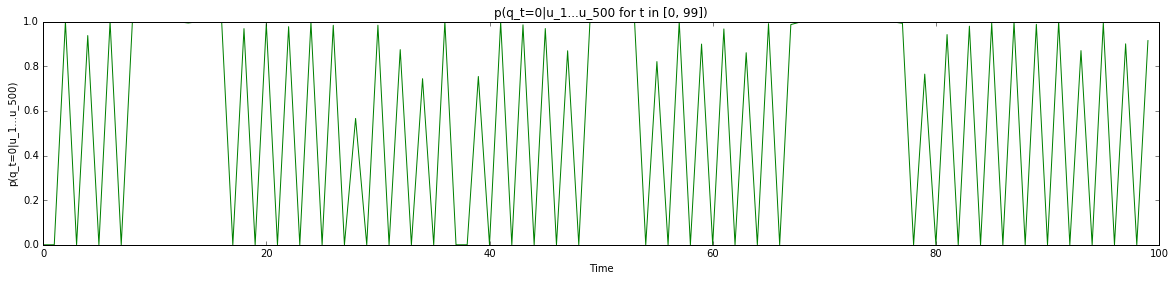

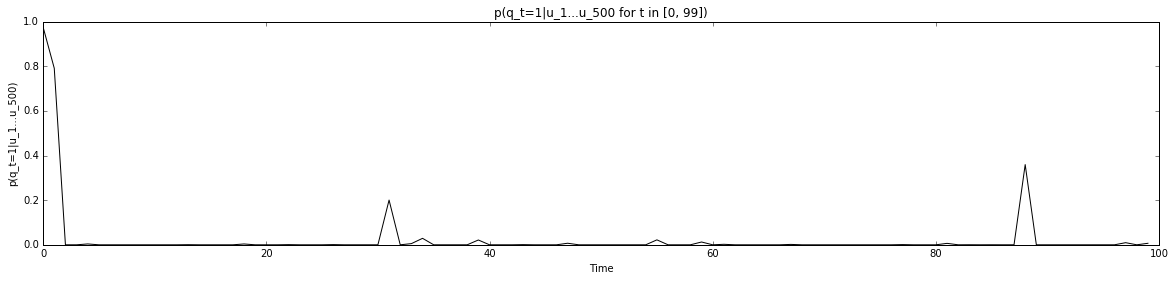

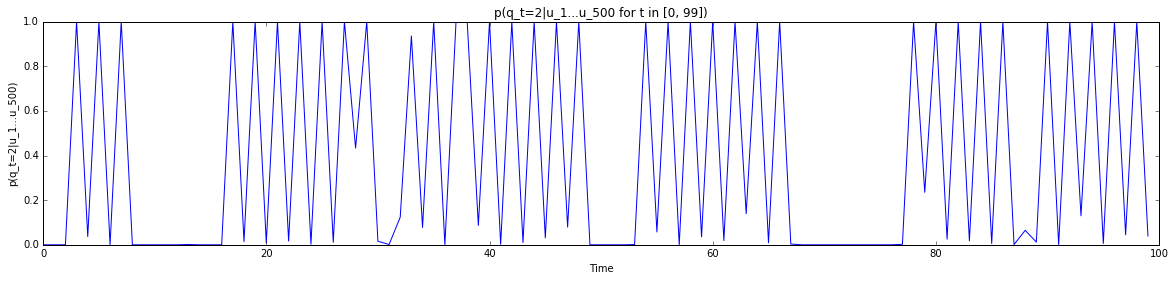

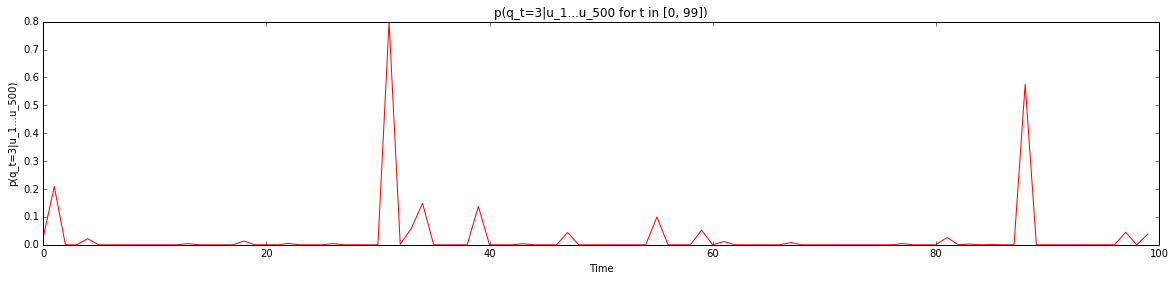

In [14]:
#plotting p(q_t|u1, ..., uT) for t in [0, 99] and all q_t in [0, 3]
time = range(100)

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 0], 'g')
plt.xlabel('Time')
plt.ylabel('p(q_t=0|u_1...u_500)')
plt.title('p(q_t=0|u_1...u_500 for t in [0, 99])')

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 1], 'k')
plt.xlabel('Time')
plt.ylabel('p(q_t=1|u_1...u_500)')
plt.title('p(q_t=1|u_1...u_500 for t in [0, 99])')

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 2], 'b')
plt.xlabel('Time')
plt.ylabel('p(q_t=2|u_1...u_500)')
plt.title('p(q_t=2|u_1...u_500 for t in [0, 99])')

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 3], 'r')
plt.xlabel('Time')
plt.ylabel('p(q_t=3|u_1...u_500)')
plt.title('p(q_t=3|u_1...u_500 for t in [0, 99])')


Let us plot the first 100 points in our dataset to check the relevance of our results.

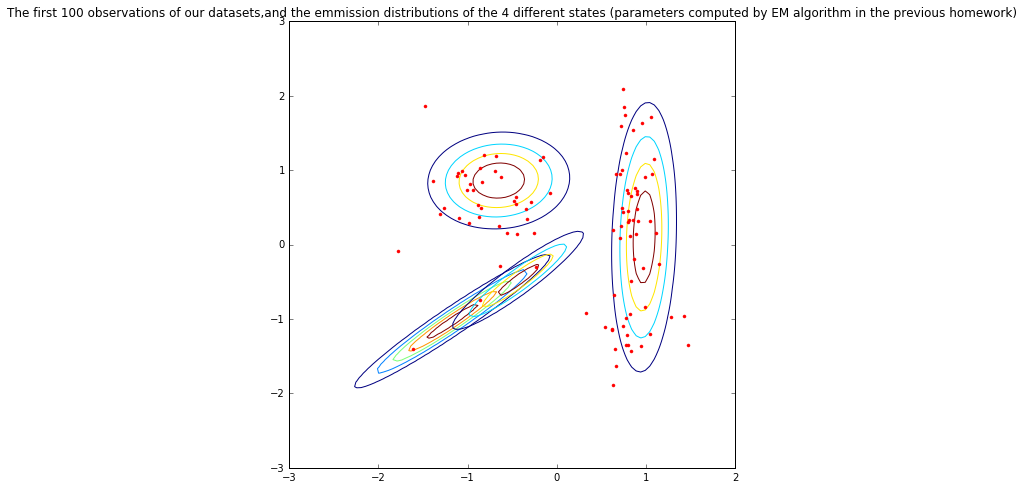

In [15]:
plt.figure(figsize=(8,8))
plt.plot(dataTest[:100, 0], dataTest[:100, 1], 'r.')

xgrid , ygrid = np.meshgrid(np.linspace(-3,2, 100),np.linspace(-3,3, 100))

zgrid = np.array([[P[0].probCond([xgrid[i, j], ygrid[i ,j]]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[P[1].probCond([xgrid[i, j], ygrid[i ,j]]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[P[2].probCond([xgrid[i, j], ygrid[i ,j]]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

zgrid = np.array([[P[3].probCond([xgrid[i, j], ygrid[i ,j]]) for j in range(len(xgrid))] for i in range(len(xgrid))], dtype='float64')
plt.contour(xgrid,ygrid,zgrid,5)

plt.title('The first 100 observations of our datasets,' 
          'and the emmission distributions of the 4 different states (parameters computed by EM algorithm in the previous homework)')

We can note that indeed most of the first 100 observations seems to have been emitted from states 0 and 2.

#### 3. EM algorithm

In [90]:
def logLikelihood(hmm, X, pqt, pqt_qt1):
    #returns the expectation of log-likelihood of the data in our hmm model
    #pqt = p(q_t|u_1, ..., u_T), pqt_qt1 = p(q_t, q_t+1|u_1, ..., u_T) can be computed using the probsScaled method of hmm class
    K = hmm.K
    T = np.shape(pqt)[0]
    
    logLike = np.sum(pqt[0,:]*[math.log(max(hmm.pi[i], 1e-323)) for i in range(K)])
    for t in range(T):
        for i in range(K):
            logLike += pqt[t, i]*math.log(max(hmm.P[i].probCond(X[t,:]), 1e-323))
            if (t<T-1):
                for j in range(K):
                    logLike += pqt_qt1[t, i, j]*math.log(max(hmm.A[i,j], 1e-323))
    return logLike

In [92]:
def EM(hmm, niter, Xtrain, Xtest):
    #EM algorihm, updates the parameters of the hmm and returns the log_likelihood of the train and test data for each iteration 
    #The hmm is assumed to have been alreardy intialized in its parameters 
    #(in our case, with means and covariances initialized with the ones obtained in the previous homework)
    logLikeTrain = np.zeros(niter)
    logLikeTest = np.zeros(niter)
    T = np.shape(Xtrain)[0]
    for k in range(niter):
        #E-step: computing p(q_t|u_1, ..., u_t) and p(q_t, q_t+1|u_1, ..., u_T)
        pqt, pqt_qt1 = hmm.probsScaled(Xtrain)
        pqtTest, pqt_qt1Test = hmm.probsScaled(Xtest)
        logLikeTrain[k] = logLikelihood(hmm, Xtrain, pqt, pqt_qt1)
        logLikeTest[k] = logLikelihood(hmm, Xtest, pqtTest, pqt_qt1Test)

        #M-step: updating pi, A, mu and Sigma of our hmm
        hmm.pi = np.copy(pqt[0,:])
        
        for i in range(hmm.K):
            for j in range(hmm.K):
                hmm.A[i,j] = np.sum(pqt_qt1[:, i, j])/np.sum(pqt[:T-1,i])
            hmm.P[i].mu = np.sum([pqt[t, i]*Xtrain[t,:] for t in range(T)], 0)/np.sum(pqt[:,i])
            hmm.P[i].Sigma = np.sum([pqt[t, i]*np.dot(
                        np.transpose(np.array([Xtrain[t,:] - hmm.P[i].mu])), np.array([Xtrain[t,:] - hmm.P[i].mu])) 
                                     for t in range(T)], 0)/np.sum(pqt[:,i])
    return logLikeTrain, logLikeTest
            
        

    


In [93]:
#Do not forget to re-initialize testHMM each time you run this cell
logLikeTrain, logLikeTest = EM(testHMM, 100, dataTrain, dataTest)

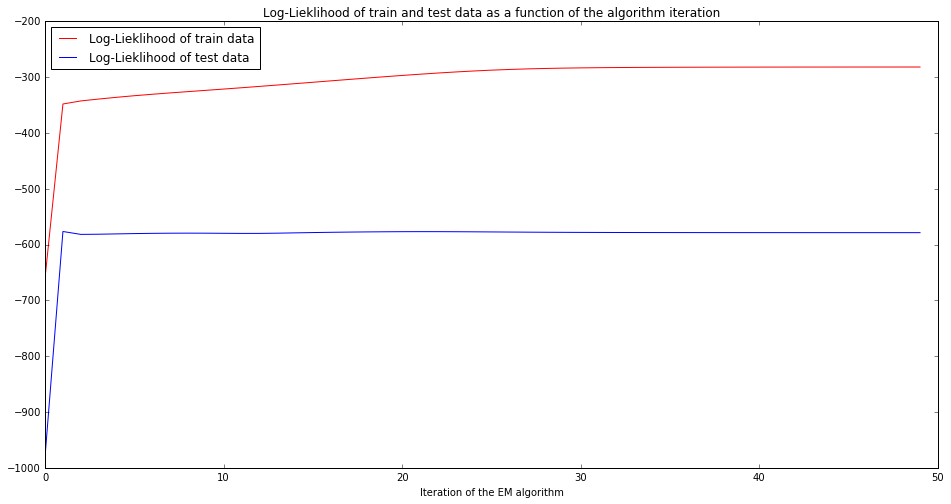

In [100]:
plt.figure(figsize=(16,8))
iterations = range(50)
plt.plot(iterations, logLikeTrain[:50], 'r')
plt.plot(iterations, logLikeTest[:50], 'b')
plt.legend(['Log-Lieklihood of train data', 'Log-Lieklihood of test data'], loc=2)
plt.xlabel('Iteration of the EM algorithm')
plt.title('Log-Lieklihood of train and test data as a function of the algorithm iteration')

In [101]:
#Taking the log-likelihood at the 10th iteration to compare with the values  on the gaussian mixture models in homework2
print('Log-Likelihood of the Train data at the 10th iteration :', logLikeTrain[9])
print('Log-Likelihood of the Test data at the 10th iteration :', logLikeTest[9])

Log-Likelihood of the Train data at the 10th iteration : -323.565289676
Log-Likelihood of the Test data at the 10th iteration : -579.545732929


Note that the HMM model took into account the sequence in which the observation were emitted. This is not the case with Gausian Mixture.

In [103]:
testHMM.A

array([[  4.17291844e-001,   3.23443626e-002,   5.50363793e-001,
          5.80400453e-095],
       [  8.62158004e-002,   8.42926010e-001,   3.53718898e-194,
          7.08581901e-002],
       [  9.21218859e-001,   6.44773035e-002,   1.43038378e-002,
          3.80545704e-064],
       [  5.52238924e-002,   7.56312809e-001,   1.88463298e-001,
          1.60638953e-011]])

We can indeed see that the transition probabilities are far from beeing equal. 
Let us compute the log-likelihood of our trained HMM on a shuffled version of the test data.

In [110]:
testHMM = HMM(4, pi, A, P) #re-initializing the hmm
np.random.shuffle(dataTest)
logLikeTrainNew, logLikeTestNew = EM(testHMM, 10, dataTrain, dataTest)

In [111]:
print('Log-Likelihood of a shuffled version of the Test data at the 10th iteration :', logLikeTestNew[9])

Log-Likelihood of a shuffled version of the Test data at the 10th iteration : -1384.2472457


In [153]:
#resuming the original order of the test data sequence
dataTest = np.loadtxt('./data/EMGaussian.test')
dataTest = designMatrixPreproc(dataTest)

#### 4.Viterbi Algorithm

In [129]:
def viterbi(hmm, X):
    K = hmm.K
    T = np.shape(X)[0]
    delta = np.zeros((T, K))
    idx = np.zeros((T, K)) #the first value will not be used
    seq = np.zeros(T)
    delta[0, :] = np.array([p.probCond(X[0,:]) for p in hmm.P])*pi
    for t in range(1, T):
        for k in range(K):
            tmp = np.array([delta[t-1, j]*hmm.A[j, k] for j in range(K)])
            idx[t, k] = np.argmax(tmp)
            delta[t, k] = hmm.P[k].probCond(X[t, :])*np.amax(tmp)
    seq[T-1] = np.argmax(delta[T-1,:])
    for t in range(T-1,0,-1):
        seq[t-1] = idx[t, int(seq[t])]
    return seq


In [130]:
def logViterbi(hmm, X):
    #log version of viterbi algorithm to avoid underflow
    K = hmm.K
    T = np.shape(X)[0]
    delta = np.zeros((T, K))
    idx = np.zeros((T, K)) #the first value will not be used
    seq = np.zeros(T)
    delta[0, :] = np.array([math.log(max(p.probCond(X[0,:]), 1e-323))  for p in hmm.P]) + [math.log(max(p, 1e-323)) for p in hmm.pi]
    for t in range(1, T):
        for k in range(K):
            tmp = np.array([delta[t-1, j] + math.log(max(hmm.A[j, k], 1e-323))  for j in range(K)])
            idx[t, k] = np.argmax(tmp)
            delta[t, k] = math.log(max(hmm.P[k].probCond(X[t, :]), 1e-323)) + np.amax(tmp)
    seq[T-1] = np.argmax(delta[T-1,:])
    for t in range(T-1,0,-1):
        seq[t-1] = idx[t, int(seq[t])]
    return seq

In [134]:
#do not forget to run the EM algorithm on testHMM before reunning the Viterbi algorithm
seq = logViterbi(testHMM, dataTest)

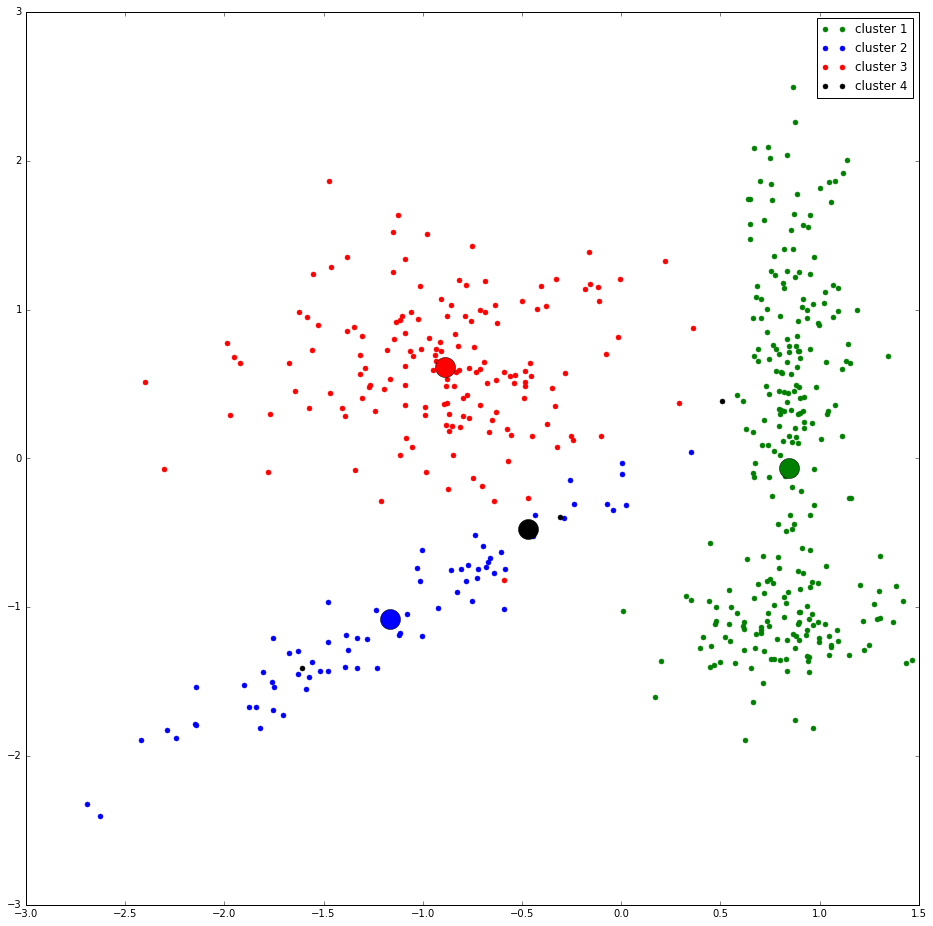

In [142]:
plt.figure(figsize=(16,16))
cluster1 = dataTest[seq == 0]
mean1 = np.mean(cluster1, 0)
mean2 = np.mean(cluster2, 0)
mean3 = np.mean(cluster3, 0)
mean4 = np.mean(cluster4, 0)

cluster2 = dataTest[seq == 1]
cluster3 = dataTest[seq == 2]
cluster4 = dataTest[seq == 3]
plt.plot(cluster1[:, 0], cluster1[:, 1], 'g.', markersize=10)
plt.plot(cluster2[:, 0], cluster2[:, 1], 'b.', markersize=10)
plt.plot(cluster3[:, 0], cluster3[:, 1], 'r.', markersize=10)
plt.plot(cluster4[:, 0], cluster4[:, 1], 'k.', markersize=10)
plt.plot(mean1[0], mean1[1], 'go', markersize=20)
plt.plot(mean2[0], mean2[1], 'bo', markersize=20)
plt.plot(mean3[0], mean3[1], 'ro', markersize=20)
plt.plot(mean4[0], mean4[1], 'ko', markersize=20)

plt.legend(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4'])


#### 5. Plotting

In [143]:
#Plotting again p(q_t|u_1, ..., u_T) for t in [0, 99] and q_t in the test data
# but this time for our hmm trained with the EM algorithm on the train data
# Ensure the EM algorithm has been runned on testHMM before running this cell
pqt, pqt_qt1 = testHMM.probsScaled(dataTest)

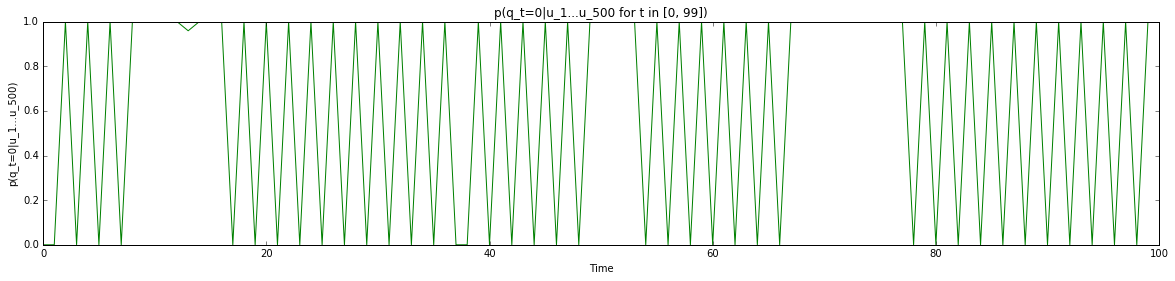

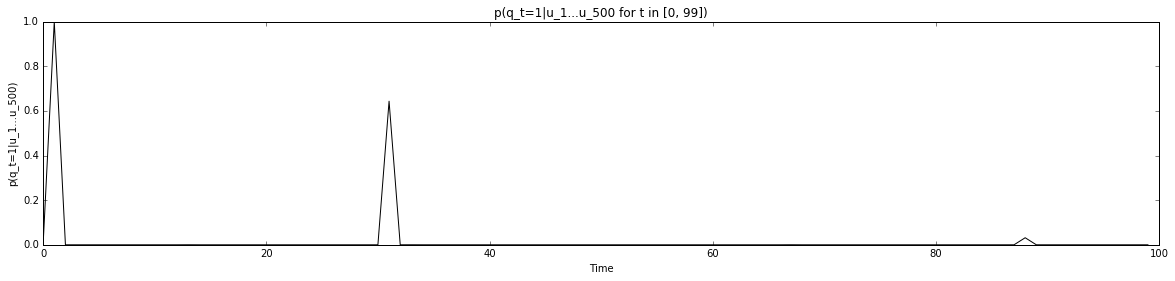

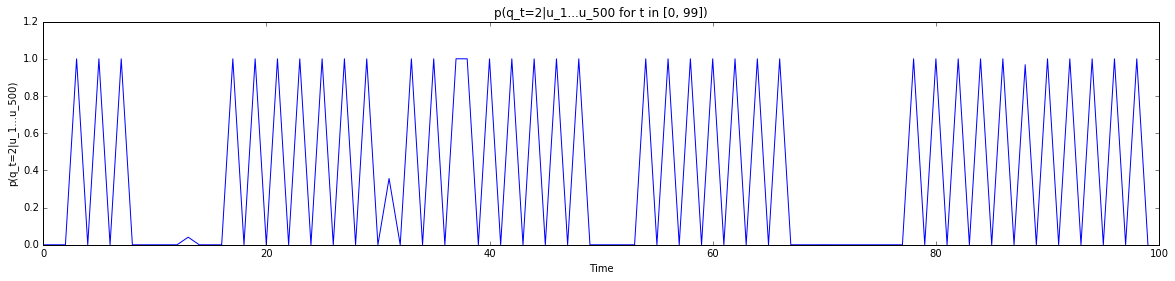

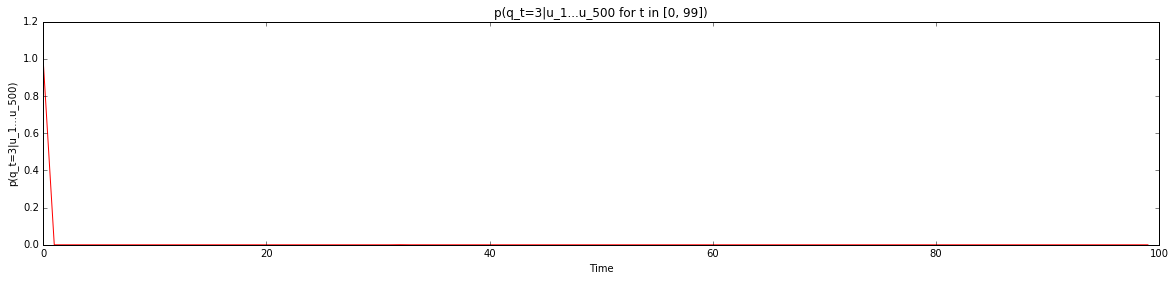

In [145]:
#plotting p(q_t|u1, ..., uT) for t in [0, 99] and all q_t in [0, 3]
time = range(100)

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 0], 'g')
plt.xlabel('Time')
plt.ylabel('p(q_t=0|u_1...u_500)')
plt.title('p(q_t=0|u_1...u_500 for t in [0, 99])')

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 1], 'k')
plt.xlabel('Time')
plt.ylabel('p(q_t=1|u_1...u_500)')
plt.title('p(q_t=1|u_1...u_500 for t in [0, 99])')

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 2], 'b')
plt.xlabel('Time')
plt.ylabel('p(q_t=2|u_1...u_500)')
plt.title('p(q_t=2|u_1...u_500 for t in [0, 99])')

plt.figure(figsize=(20,4))
plt.plot(time, pqt[:100, 3], 'r')
plt.xlabel('Time')
plt.ylabel('p(q_t=3|u_1...u_500)')
plt.title('p(q_t=3|u_1...u_500 for t in [0, 99])')


#### 6. Comparing most likeli states and Viterbi decoding

In [147]:
#compute most likely state for each test data points, according to the matginal probability p(q_t|u_1, ..., u_T)
mostLikely = np.argmax(pqt, 1)

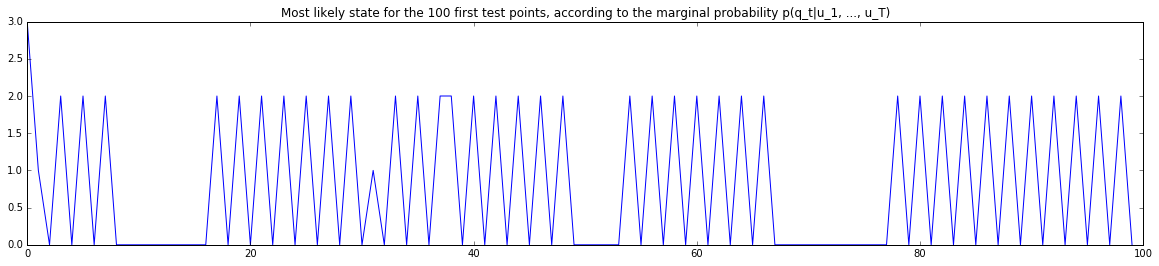

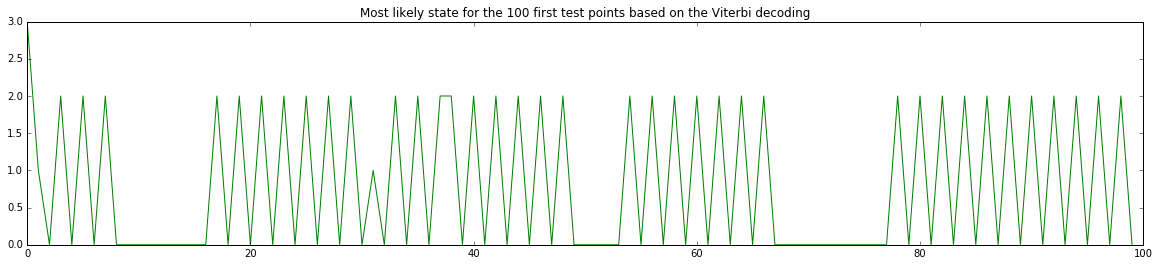

In [152]:
time = range(100)
plt.figure(figsize=(20,4))
plt.plot(time, mostLikely[:100])
plt.title('Most likely state for the 100 first test points, according to the marginal probability p(q_t|u_1, ..., u_T)')

plt.figure(figsize=(20,4))
plt.plot(time, seq[:100], 'g')
plt.title('Most likely state for the 100 first test points based on the Viterbi decoding')